## Required libraries

In [1]:
# Data Preprocessing
import os
import glob
import time
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import warnings
# Disable the warning
warnings.filterwarnings("ignore")

# Model Training
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

# Image preprocessing
import cv2
from torchvision import transforms
from torch.utils.data import Dataset
import torchvision.models as models
from torchvision.models import vgg16_bn, VGG16_BN_Weights
import torchvision.utils as utils

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
torch.manual_seed(42)

## Data used in this model training is from Kaggle:

```https://www.kaggle.com/datasets/chetankv/dogs-cats-images```

## Preprocessing the data

In [2]:
# Define the base directory path
data_dir='/Users/kimrui/aiap-projects/Image Classification with Attention/data/Cat_Dog_Dataset1'
# Define the class names and their corresponding targets
class_names = {'cat': 0, 'dog': 1}

# Initialize empty lists to store the image filepaths and targets
filepaths = []
targets = []

filepaths_to_plot = []
targets_to_plot = []
# IMPORTANT - uncomment for if fixed plotting images to be used
# filepaths_random = []
# targets_random = []
# random.seed(42)

# Iterate over the class directories and collect the filepaths
for class_name, target in class_names.items():
    class_dir = os.path.join(data_dir, class_name)
    file_pattern = os.path.join(class_dir, '*.jpg')
    filepaths.extend(glob.glob(file_pattern))
    targets.extend([target] * len(glob.glob(file_pattern)))

    # IMPORTANT - uncomment for if fixed plotting images to be used
    # Randomly select 4 data out of each label
    # filepaths_random.extend(glob.glob(file_pattern))
    # targets_random.extend([target] * len(glob.glob(file_pattern)))
    # filepaths_to_plot.extend(random.sample(filepaths_random, 4)) 
    # targets_to_plot.extend(random.sample(targets_random, 4))
    # filepaths_random = []
    # targets_random = []

# Create a DataFrame from the collected filepaths and targets
data = {'images': filepaths, 'target': targets}
df = pd.DataFrame(data)

print(df)

                                                 images  target
0     /Users/kimrui/aiap-projects/Image Classificati...       0
1     /Users/kimrui/aiap-projects/Image Classificati...       0
2     /Users/kimrui/aiap-projects/Image Classificati...       0
3     /Users/kimrui/aiap-projects/Image Classificati...       0
4     /Users/kimrui/aiap-projects/Image Classificati...       0
...                                                 ...     ...
9995  /Users/kimrui/aiap-projects/Image Classificati...       1
9996  /Users/kimrui/aiap-projects/Image Classificati...       1
9997  /Users/kimrui/aiap-projects/Image Classificati...       1
9998  /Users/kimrui/aiap-projects/Image Classificati...       1
9999  /Users/kimrui/aiap-projects/Image Classificati...       1

[10000 rows x 2 columns]


In [3]:
# IMPORTANT - uncomment for if using default images to be used
# For generating default images(used in explanatory article) for plotting 
file_names = ['cat/cat.3352.jpg', 'cat/cat.3029.jpg', 'cat/cat.1524.jpg', 'dog/dog.117.jpg', 'dog/dog.2623.jpg', 'dog/dog.1286.jpg', 'dog/dog.2029.jpg', 'cat/cat.809.jpg']
for file_name in file_names:
    file_path = os.path.join(data_dir, file_name)
    filepaths_to_plot.append(file_path)
    if 'cat/' in file_name:
        targets_to_plot.append(0)
    elif 'dog/' in file_name:
        targets_to_plot.append(1)

data_to_plot = {'images': filepaths_to_plot, 'target': targets_to_plot}
df_to_plot = pd.DataFrame(data_to_plot).sample(frac = 1, random_state = 42)

print(df_to_plot)

                                              images  target
1  /Users/kimrui/aiap-projects/Image Classificati...       0
5  /Users/kimrui/aiap-projects/Image Classificati...       1
0  /Users/kimrui/aiap-projects/Image Classificati...       0
7  /Users/kimrui/aiap-projects/Image Classificati...       0
2  /Users/kimrui/aiap-projects/Image Classificati...       0
4  /Users/kimrui/aiap-projects/Image Classificati...       1
3  /Users/kimrui/aiap-projects/Image Classificati...       1
6  /Users/kimrui/aiap-projects/Image Classificati...       1


In [4]:
# Split train into train and val
X_train, X_val, y_train, y_val = train_test_split(df['images'], df['target'], test_size=0.2, stratify=df['target'], random_state=1234)

## Image Transformer

In [5]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(256),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [6]:
class ImageDataset(Dataset):
    
    def __init__(self, data_paths, labels, transform=None, mode='train'):
         self.data = data_paths
         self.labels = labels
         self.transform = transform
         self.mode = mode
    def __len__(self):
       return len(self.data)
    
    def __getitem__(self,idx):
        image_path = self.data[idx]
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = transforms.ToPILImage()(img)
        # img = Image.open(image_path)

        if self.transform is not None:
          img = self.transform(img)
        
        labels = torch.tensor(self.labels[idx], dtype=torch.float32)

        return img, labels

In [7]:
train_dataset = ImageDataset(data_paths=X_train.values, labels=y_train.values, transform=train_transform)
val_dataset = ImageDataset(data_paths=X_val.values, labels=y_val.values, transform=val_transform)

train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

plot_dataset = ImageDataset(data_paths=df_to_plot['images'].values, labels=df_to_plot['target'].values, transform=train_transform)
plot_data_loader = DataLoader(plot_dataset, batch_size=8, shuffle=False)

In [8]:
# Shape of inputs = (batch_size, channels, height, width) & Shape of labels = (batch_size)
for batch in val_data_loader:
    inputs, labels = batch
    print(inputs.shape)
    print(labels.shape)
    print(len(val_data_loader))
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])
63


In [9]:
for batch in plot_data_loader:
    inputs, labels = batch
    inputs_to_plot = inputs.to(device)

print(inputs.shape)
print(labels)
print(len(plot_data_loader))

torch.Size([8, 3, 224, 224])
tensor([0., 1., 0., 0., 0., 1., 1., 1.])
1


## Model Structure

In [235]:
# Load the pretrained VGG16 model
model = models.vgg16_bn(pretrained=True)

# Print the model architecture
print(model)
del model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

<figure>
  <img src="/Users/kimrui/aiap-projects/Image Classification with Attention/Image/VGG16 with Attention Block.png" width="60%"> 
  <figcaption>VGG16 CNN with two attention maps trained with two feature maps (Local and Global Maps).</figcaption>
</figure>

<figure>
  <img src="/Users/kimrui/aiap-projects/Image Classification with Attention/Image/Attention Block.png" width="60%"> 
  <figcaption>Global and intermediate feature maps to train the attention maps - Pool5 & Pool3 and Pool5 & Pool4.</figcaption>
</figure>

## Model Structure

### Attention Block

In [15]:
class AttentionBlock(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True): #256, 512, 256, 4
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv2d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False) 
        self.W_g = nn.Conv2d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)  
        self.phi = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
        
    def forward(self, l, g):
        N, C, H, W = l.size()
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        if self.up_factor > 1:
            g_ = nn.functional.interpolate(g_, scale_factor=self.up_factor, mode='bilinear', align_corners=False)
        c = self.phi(nn.functional.relu(l_ + g_)) # batch_sizex1xHxW
        
        # compute attn map
        if self.normalize_attn:
            a = nn.functional.softmax(c.view(N,1,-1), dim=2).view(N,1,H,W)
        else:
            a = torch.sigmoid(c) # if normalize_attn == False
        # re-weight the local feature
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxHxW
        if self.normalize_attn:
            output = f.view(N,C,-1).sum(dim=2) # weighted sum
        else:
            output = nn.functional.adaptive_avg_pool2d(f, (1,1)).view(N,C) # global average pooling
        return a, output

### VGG16 with Attention Block

In [16]:
class AttnVGG(nn.Module):
    def __init__(self, num_classes, normalize_attn=False, dropout=None):
        super(AttnVGG, self).__init__()

        # VGG16 CNN Blocks
        net = models.vgg16_bn(weights=VGG16_BN_Weights.DEFAULT)
        self.conv_block1 = nn.Sequential(*list(net.features.children())[0:6]) # nn.Sequential constructor expects each layer to be passed as a separate argument, rather than as a list or tuple. * used to unpack liste of layers
        self.conv_block2 = nn.Sequential(*list(net.features.children())[7:13])
        self.conv_block3 = nn.Sequential(*list(net.features.children())[14:23])
        self.conv_block4 = nn.Sequential(*list(net.features.children())[24:33])
        self.conv_block5 = nn.Sequential(*list(net.features.children())[34:43])
        self.pool = nn.AvgPool2d(7, stride=1) # kernel size of 7x7 and a stride of 1

        # Attention Block
        # initialize the attention blocks defined above
        self.attn1 = AttentionBlock(256, 512, 256, 4, normalize_attn=normalize_attn)
        self.attn2 = AttentionBlock(512, 512, 256, 2, normalize_attn=normalize_attn)

        # Dropout Layer
        self.dpt = None
        if dropout is not None:
            self.dpt = nn.Dropout(dropout)

        # Output layer    
        self.cls = nn.Linear(in_features=512+512+256, out_features=num_classes, bias=True)
       
        self.reset_parameters(self.attn1)
        self.reset_parameters(self.attn2)
        self.reset_parameters(self.cls)


    def reset_parameters(self, module): # Ensure the weights and biases are properly initialized before training the model
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)

    def forward(self, x):
        # CNN Block
        block1 = self.conv_block1(x)           # /1
        pool1 = nn.MaxPool2d(2, 2)(block1)     # /2
        block2 = self.conv_block2(pool1)       # /2
        pool2 = nn.MaxPool2d(2, 2)(block2)     # /4
        block3 = self.conv_block3(pool2)       # /4
        pool3 = nn.MaxPool2d(2, 2)(block3)     # /8
        block4 = self.conv_block4(pool3)       # /8
        pool4 = nn.MaxPool2d(2, 2)(block4)     # /16
        block5 = self.conv_block5(pool4)       # /16
        pool5 = nn.MaxPool2d(2, 2)(block5)     # /32 #Global feature vector is the resultant vector after MaxPool2d of block 5
        N, __, __, __ = pool5.size()           # N represents the batch size
        
        # Attention Block
        a1, g1 = self.attn1(pool3, pool5)      # Attention map 1 - pool3 Intermediate feature map/ pool5 Global feature map
        a2, g2 = self.attn2(pool4, pool5)      # Attention map 2 - pool4 Intermediate feature map/ pool5 Global feature map
        g = self.pool(pool5).view(N,-1)       # Connection between VGG16 CNN and Attention block - Global feature map reshapes the tensor to have N rows and 512 columns
        
        # Flattening
        g_hat = torch.cat((g,g1,g2), dim=1)    # Flattening - shape (N, C)

        if self.dpt is not None:               # Dropout layer
            g_hat = self.dpt(g_hat)
        out = self.cls(g_hat)                  # Linear layer

        return out, a1, a2
    
    def count_trainable_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [17]:
class VGG(nn.Module):
    def __init__(self, num_classes, gap=False):
        super(VGG, self).__init__()
        self.gap = gap
        net = models.vgg16_bn(weights=VGG16_BN_Weights.DEFAULT) #weights=VGG16_BN_Weights.DEFAULT
        self.conv_block1 = nn.Sequential(*list(net.features.children())[0:6])
        self.conv_block2 = nn.Sequential(*list(net.features.children())[7:13])
        self.conv_block3 = nn.Sequential(*list(net.features.children())[14:23])
        self.conv_block4 = nn.Sequential(*list(net.features.children())[24:33])
        self.conv_block5 = nn.Sequential(*list(net.features.children())[34:43])
        if self.gap:
            self.pool = nn.AvgPool2d(7, stride=1)
            self.cls = nn.Linear(in_features=512, out_features=num_classes, bias=True)
        else:
            self.dense = nn.Sequential(*list(net.classifier.children())[:-1])
            self.cls = nn.Linear(in_features=4096, out_features=num_classes, bias=True)

        # initialize
        nn.init.normal_(self.cls.weight, 0., 0.01)
        nn.init.constant_(self.cls.bias, 0.)
    def forward(self, x):
        block1 = self.conv_block1(x)       # /1
        pool1 = nn.MaxPool2d(2, 2)(block1) # /2
        block2 = self.conv_block2(pool1)   # /2
        pool2 = nn.MaxPool2d(2, 2)(block2) # /4
        block3 = self.conv_block3(pool2)   # /4
        pool3 = nn.MaxPool2d(2, 2)(block3) # /8
        block4 = self.conv_block4(pool3)   # /8
        pool4 = nn.MaxPool2d(2, 2)(block4) # /16
        block5 = self.conv_block5(pool4)   # /16
        pool5 = nn.MaxPool2d(2, 2)(block5) # /32
        N, __, __, __ = pool5.size()
        if self.gap:
            g = self.pool(pool5).view(N,-1)
        else:
            g = self.dense(pool5.view(N,-1))
        out = self.cls(g)
        a1, a2 = None, None
        return [out, a1, a2]
    
    def count_trainable_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## Model Training

### Training and Validation Steps

In [239]:
def train_model(model, train_data_loader, val_data_loader, criterion, optimizer, num_epochs, CNN_trainable=False):
    start_time = time.time()

    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    model.to(device)
    #model = nn.DataParallel(model).to(device)
    criterion.to(device)


    if not CNN_trainable: # Not trainable and freeze CNN block
        # Freeze the parameters of the VGG16 blocks
        for param in model.conv_block1.parameters():
            param.requires_grad = False
        for param in model.conv_block2.parameters():
            param.requires_grad = False
        for param in model.conv_block3.parameters():
            param.requires_grad = False
        for param in model.conv_block4.parameters():
            param.requires_grad = False
        for param in model.conv_block5.parameters():
            param.requires_grad = False

    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    train_auc=[]

    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_aucs=[]

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        running_accuracy = 0.0
        running_precision = 0.0
        running_recall = 0.0
        running_auc = 0.0
        
        model.train() #Dropout layer is only activated during training process

        # Run the training batches
        for batch in train_data_loader:

            optimizer.zero_grad()
            
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device).float()
        
            predictions, _, _ = model(inputs)
            prediction_labels = torch.round(torch.sigmoid(predictions)).to(device).squeeze(1)
            predictions = predictions.to(device).squeeze(1)

            loss = criterion(predictions, labels)
            running_loss += loss.item()
                
            loss.backward()
            optimizer.step()

            # Calculate the metric scores
            accuracy = accuracy_score(labels.cpu().detach().numpy(), prediction_labels.cpu().detach().numpy())
            running_accuracy += accuracy

            precision = precision_score(labels.cpu().detach().numpy(), prediction_labels.cpu().detach().numpy(), zero_division=0) 
            running_precision += precision

            recall = recall_score(labels.cpu().detach().numpy(), prediction_labels.cpu().detach().numpy(), zero_division=0, average='micro')
            running_recall += recall
                 
            try:
                auc = roc_auc_score(labels.cpu().detach().numpy(), prediction_labels.cpu().detach().numpy())
                running_auc += auc
            except:
                auc = 0
                running_auc += auc

        epoch_loss = running_loss/len(train_data_loader)
        train_losses.append(epoch_loss)

        epoch_accuracy = running_accuracy/len(train_data_loader)
        train_accuracies.append(epoch_accuracy) 

        epoch_precision = running_precision/len(train_data_loader)
        train_precisions.append(epoch_precision)

        epoch_recall = running_recall/len(train_data_loader)
        train_recalls.append(epoch_recall)  

        epoch_auc = running_auc/len(train_data_loader)
        train_auc.append(epoch_auc)

        print(f'Epoch:{epoch+1:2} >>>> Train Loss:{epoch_loss:10.8f} --- Train Accuracy:{epoch_accuracy:10.8f} --- Train Precision:{epoch_precision:10.8f} --- Train Recalls:{epoch_recall:10.8f} --- Train AUC:{epoch_auc:10.8f}')
        
    
        # Validation 
        model.eval()
        running_val_loss = 0.0
        running_val_accuracy = 0.0
        running_val_precision = 0.0
        running_val_recall = 0.0
        running_val_auc = 0.0
        
        with torch.no_grad():
            for batch in val_data_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device).float()  

                predictions, _, _ = model(inputs)
                prediction_labels = torch.round(torch.sigmoid(predictions)).to(device).squeeze(1)
                predictions = predictions.to(device).squeeze(1)
                
                loss = criterion(predictions, labels)
                running_val_loss += loss.item()

                # Calculate the metric scores
                accuracy = accuracy_score(labels.cpu().detach().numpy(), prediction_labels.cpu().detach().numpy())
                running_val_accuracy += accuracy

                precision = precision_score(labels.cpu().detach().numpy(), prediction_labels.cpu().detach().numpy(), zero_division=0) 
                running_val_precision += precision

                recall = recall_score(labels.cpu().detach().numpy(), prediction_labels.cpu().detach().numpy(), zero_division=0, average='micro')
                running_val_recall += recall
                 
                try:
                    auc = roc_auc_score(labels.cpu().detach().numpy(), prediction_labels.cpu().detach().numpy())
                    running_val_auc += auc
                except:
                    auc = 0
                    running_val_auc += auc

        val_loss = running_val_loss/len(val_data_loader)
        val_losses.append(val_loss)

        val_accuracy = running_val_accuracy/len(val_data_loader)
        val_accuracies.append(val_accuracy)

        val_precision = running_val_precision/len(val_data_loader)
        val_precisions.append(val_precision)

        val_recall = running_val_recall/len(val_data_loader)
        val_recalls.append(val_recall)

        val_auc = running_val_auc/len(val_data_loader)
        val_aucs.append(val_auc)


        print(f'Epoch:{epoch+1} >>>> Val Loss:{val_loss:10.8f} --- Val Accuracy:{val_accuracy:10.8f} --- Val Precision:{val_precision:10.8f} --- Val Recall:{val_recall:10.8f} --- Val AUC:{val_auc:10.8f}')
            
    output_train = {
                'train_accuracies': train_accuracies,
                'train_losses': train_losses,
                'train_precisions': train_precisions, 
                'train_recalls': train_recalls,
                'train_auc': train_auc
             }
    
    output_val = {
                'val_accuracies': val_accuracies,
                'val_losses': val_losses,
                'val_precisions': val_precisions, 
                'val_recalls': val_recalls,
                'val_auc': val_aucs
             }
    
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed
    
    return model, output_train, output_val

In [240]:
def save_model(model, epochs, model_name):
    # Save the model with the epoch number in the file name
    model_path = f'model/{model_name}_epoch{epochs}.pth'
    torch.save(model.state_dict(), model_path)

## Analysizing Attention Growth

#### VGG With Attention

In [241]:
base_model_attn = AttnVGG(num_classes=1, normalize_attn=False, dropout=None) #normalize_attn False for sigmoid alignment scoring normalisation and True for softmax normalisation

In [242]:
criterion = torch.nn.BCEWithLogitsLoss() #binary cross entropy loss
optimizer = torch.optim.Adam(base_model_attn.parameters(), lr=1e-4)

CNN_trainable = False
model_name = 'AttnVGG16_Softmax'

In [ ]:
# Continue training from the previously trained model
epochs = 1 # Train for additional epochs
model1, output_train_attn1, output_val_attn1 = train_model(base_model_attn, train_data_loader, val_data_loader, criterion, optimizer, epochs, CNN_trainable)

Baseline_Grid = utils.make_grid(inputs_to_plot, nrow=8, scale_each=True, normalize=True)     
_, a1_1, a2_1 = model1(inputs_to_plot)

save_model(model1, epochs, model_name)
del base_model_attn #clear memory for more RAMs

In [ ]:
# Continue training from the previously trained model
epochs = 5 # Train for additional epochs
model2, output_train_attn2, output_val_attn2 = train_model(model1, train_data_loader, val_data_loader, criterion, optimizer, epochs, CNN_trainable)
 
_, a1_2, a2_2 = model2(inputs_to_plot)

save_model(model2, epochs, model_name)
del model1

In [ ]:
# Continue training from the previously trained model
epochs = 20 # Train for additional epochs
model3, output_train_attn3, output_val_attn3 = train_model(model2, train_data_loader, val_data_loader, criterion, optimizer, epochs, CNN_trainable)
    
_, a1_3, a2_3 = model3(inputs_to_plot)

save_model(model3, epochs, model_name)
del model2
del model3

## Visualising Attention of VGG Model

In [191]:
def visualize_attention(Baseline_Grid, attn_map, up_factor, no_attention=False):
    # compute the heatmap
    if up_factor > 1:
        attn_map = nn.functional.interpolate(attn_map, scale_factor=up_factor, mode='bilinear', align_corners=False)
        
    attn = utils.make_grid(attn_map, nrow=8, scale_each=True, normalize=True)
    attn = attn.permute((1, 2, 0)).mul(255).byte().cpu().numpy() # mul(255) to convert the values in the array from floating-point representation (between 0 to 1) to integer representation (0 and 255)
    attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255

    I = nn.functional.interpolate(Baseline_Grid.unsqueeze(0), size=(attn.shape[0],attn.shape[1]), mode='bilinear', align_corners=False)
    I = I.squeeze(0)
    # To change the convention of tensor (Channel, Height, Width) to image processing shape (Height, Width, Channel)
    img = I.permute((1, 2, 0)).cpu().numpy() #Height index 1 to index 0, Width index 2 to index 1 and Channel index to index 0
    
    if no_attention:
        return torch.from_numpy(img)
    else:
        vis = 0.6 * img + 0.4 * attn
        return torch.from_numpy(vis)

### Progress of Model Learning to improve its Attention Map

In [362]:
# IMPORTANT - uncomment if loading model to general attention maps

# model1 = AttnVGG(num_classes=1, normalize_attn=False, dropout=0)
# model2 = AttnVGG(num_classes=1, normalize_attn=False, dropout=0)
# model3 = AttnVGG(num_classes=1, normalize_attn=False, dropout=0)
# model1.load_state_dict(torch.load(f'/Users/kimrui/aiap-projects/Image Classification with Attention/model/{model_name}_epoch1.pth'))
# model2.load_state_dict(torch.load(f'/Users/kimrui/aiap-projects/Image Classification with Attention/model/{model_name}_epoch5.pth'))
# model3.load_state_dict(torch.load(f'/Users/kimrui/aiap-projects/Image Classification with Attention/model/{model_name}_epoch20.pth'))
# model1.to(device)
# model2.to(device)
# model3.to(device)

# Baseline_Grid = utils.make_grid(inputs_to_plot, nrow=8, scale_each=True, normalize=True)   
# _, a1_1, a2_1 = model1(inputs_to_plot)
# _, a1_2, a2_2 = model2(inputs_to_plot)
# _, a1_3, a2_3 = model3(inputs_to_plot)

# del model1, model2, model3

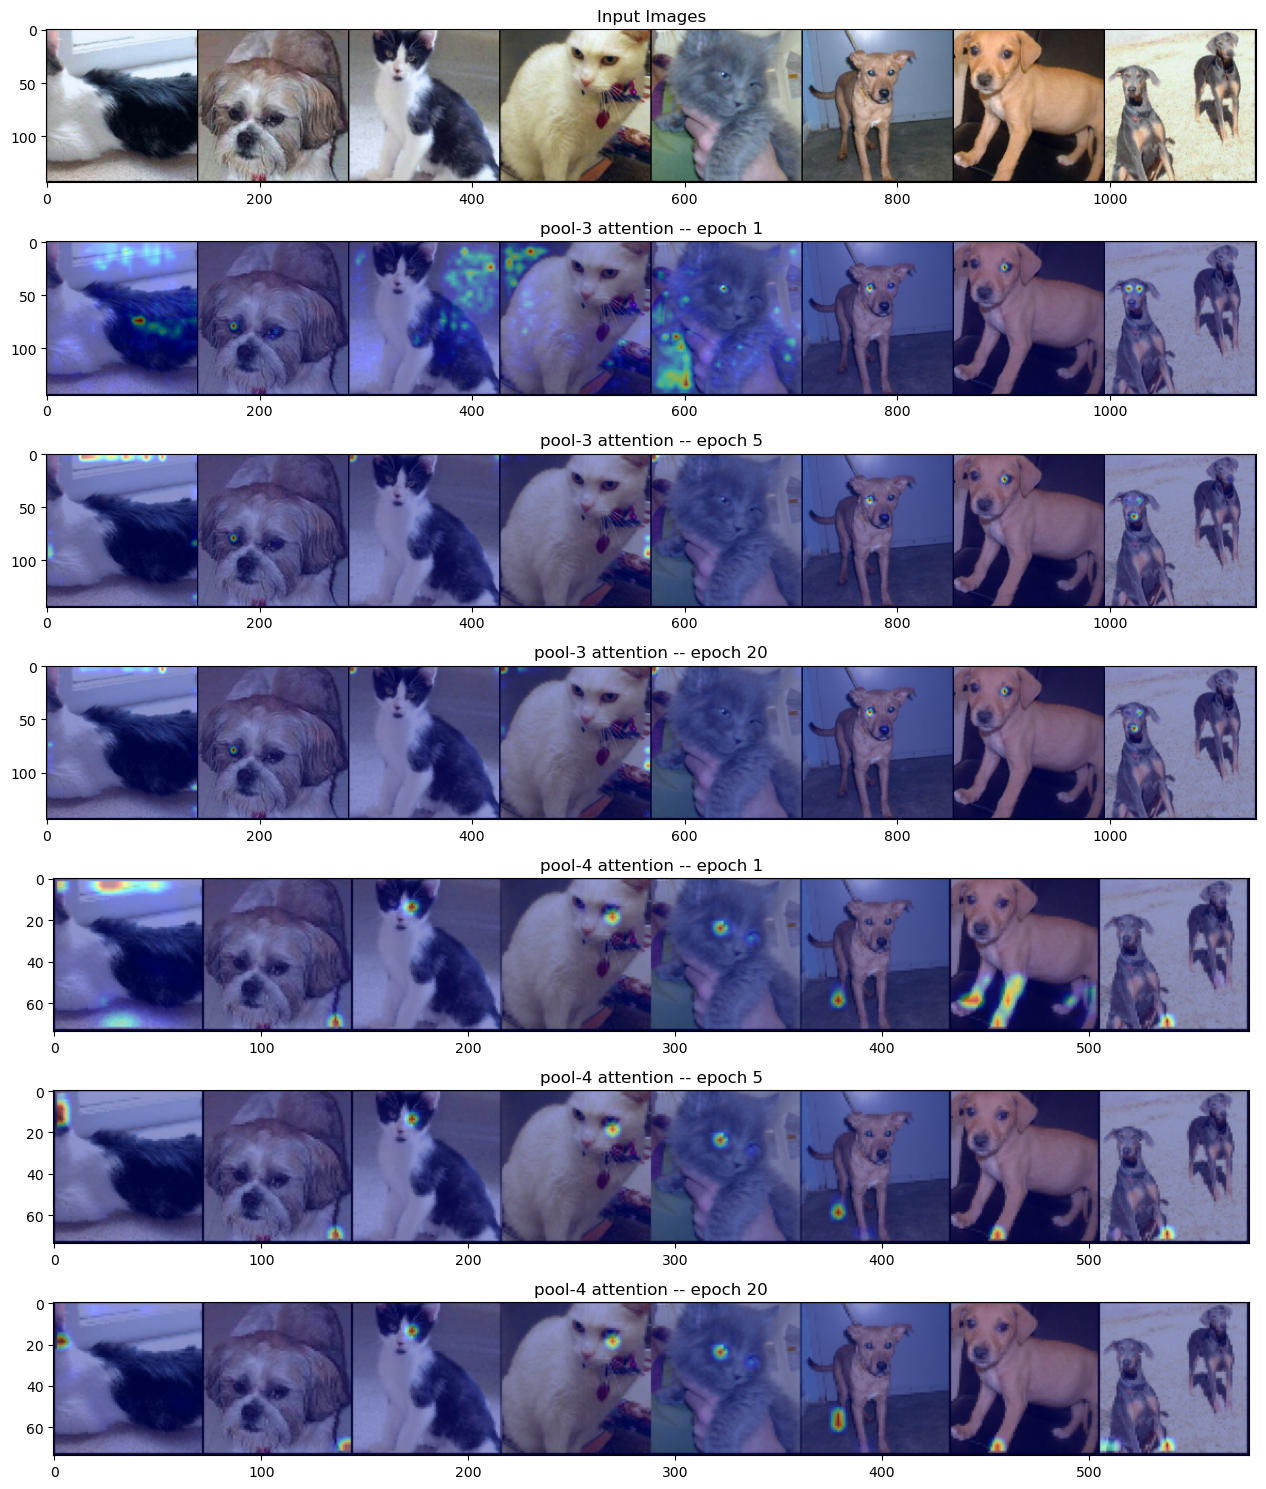

In [247]:
original_img = visualize_attention(Baseline_Grid, a1_1, up_factor=5, no_attention=True)

first_attention1 = visualize_attention(Baseline_Grid, a1_1, up_factor=5, no_attention=False)
first_attention2 = visualize_attention(Baseline_Grid, a1_2, up_factor=5, no_attention=False)
first_attention3 = visualize_attention(Baseline_Grid, a1_3, up_factor=5, no_attention=False)

second_attention1 = visualize_attention(Baseline_Grid, a2_1, up_factor=5, no_attention=False)
second_attention2 = visualize_attention(Baseline_Grid, a2_2, up_factor=5, no_attention=False)
second_attention3 = visualize_attention(Baseline_Grid, a2_3, up_factor=5, no_attention=False)

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1,figsize=(20, 15))

ax1.imshow(original_img)
ax2.imshow(first_attention1)
ax3.imshow(first_attention2)
ax4.imshow(first_attention3)

ax5.imshow(second_attention1)
ax6.imshow(second_attention2)
ax7.imshow(second_attention3)

ax1.title.set_text('Input Images')
ax2.title.set_text('pool-3 attention -- epoch 1')
ax3.title.set_text('pool-3 attention -- epoch 5')
ax4.title.set_text('pool-3 attention -- epoch 20')

ax5.title.set_text('pool-4 attention -- epoch 1')
ax6.title.set_text('pool-4 attention -- epoch 5')
ax7.title.set_text('pool-4 attention -- epoch 20')

plt.tight_layout()
plt.show()

The attention-based method can potentially outperform a simple dense layer approach for several reasons:

1. Interpretability: The attention mechanism allows the network to focus on relevant regions of the input image, mimicking the visual exploration pattern/features of dogs and cats who focus more on the eye or the snout rather than irrelevant areas such as background. This interpretability can provide insights into the decision-making process of the network and help identify the important features contributing to the classification.

2. Discriminative Features: The deeper layers of the network tend to learn more discriminative features compared to shallower layers. By incorporating attention modules that utilize intermediate feature maps, the attention-based method can capture and emphasize these discriminative features, leading to improved classification performance.

3. Regularization: The attention-based method encourages attention maps to concentrate more on relevant regions of interest (ROIs). This regularization helps the network focus on important features and suppress irrelevant or noisy information, leading to better discrimination between dog and cat cases.

4. Performance Improvement: The attention-based method has shown state-of-the-art performance for image classification, even without additional regularization. It can further improve performance when reference ROIs are available, demonstrating its effectiveness in leveraging prior information to refine both the classification performance and attention maps.

It's important to note that the specific performance improvement of the attention-based method over a simple dense layer approach may vary depending on the dataset, network architecture, and other factors. However, the attention mechanism offers the potential for improved interpretability and discrimination, which can contribute to better classification results.

## Comparison: AttnVGG vs VGG

#### With Attention

In [29]:
base_model_attn = AttnVGG(num_classes=1, normalize_attn=False, dropout=None)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
torch.manual_seed(42)

criterion = torch.nn.BCEWithLogitsLoss() #binary cross entropy loss
optimizer = torch.optim.Adam(base_model_attn.parameters(), lr=1e-4)

CNN_trainable = False
model_name = 'AttnVGG16_Sigmoid_Comparison'

In [ ]:
# Continue training from the previously trained model
epochs = 15 # Train for additional epochs
model_attn_comparison, output_train_attn_comparison, output_val_attn_comparison = train_model(base_model_attn, train_data_loader, val_data_loader, criterion, optimizer, epochs, CNN_trainable)

save_model(model_attn_comparison, epochs, model_name)
del base_model_attn
del model_attn_comparison

#### Without Attention

In [32]:
base_model = VGG(num_classes=1, gap=False)

In [33]:
criterion = torch.nn.BCEWithLogitsLoss() #binary cross entropy loss
optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-4)

CNN_trainable = False
model_name ='VGG16_Sigmoid_Comparison'

In [ ]:
epochs = 15 
model_comparison, output_train_comparison, output_val_comparison = train_model(base_model, train_data_loader, val_data_loader, criterion, optimizer, epochs, CNN_trainable)

save_model(model_comparison, epochs, model_name)
del base_model
del model_comparison

In [35]:
def plot_metrics(train_metrics, val_metrics, metric_name, subplot):
    epochs = range(1, len(train_metrics) + 1)

    plt.subplot(subplot)
    plt.plot(epochs, train_metrics, 'b', label=f'Train {metric_name}')
    plt.plot(epochs, val_metrics, 'r', label=f'Val {metric_name}')
    plt.title(f'Train and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

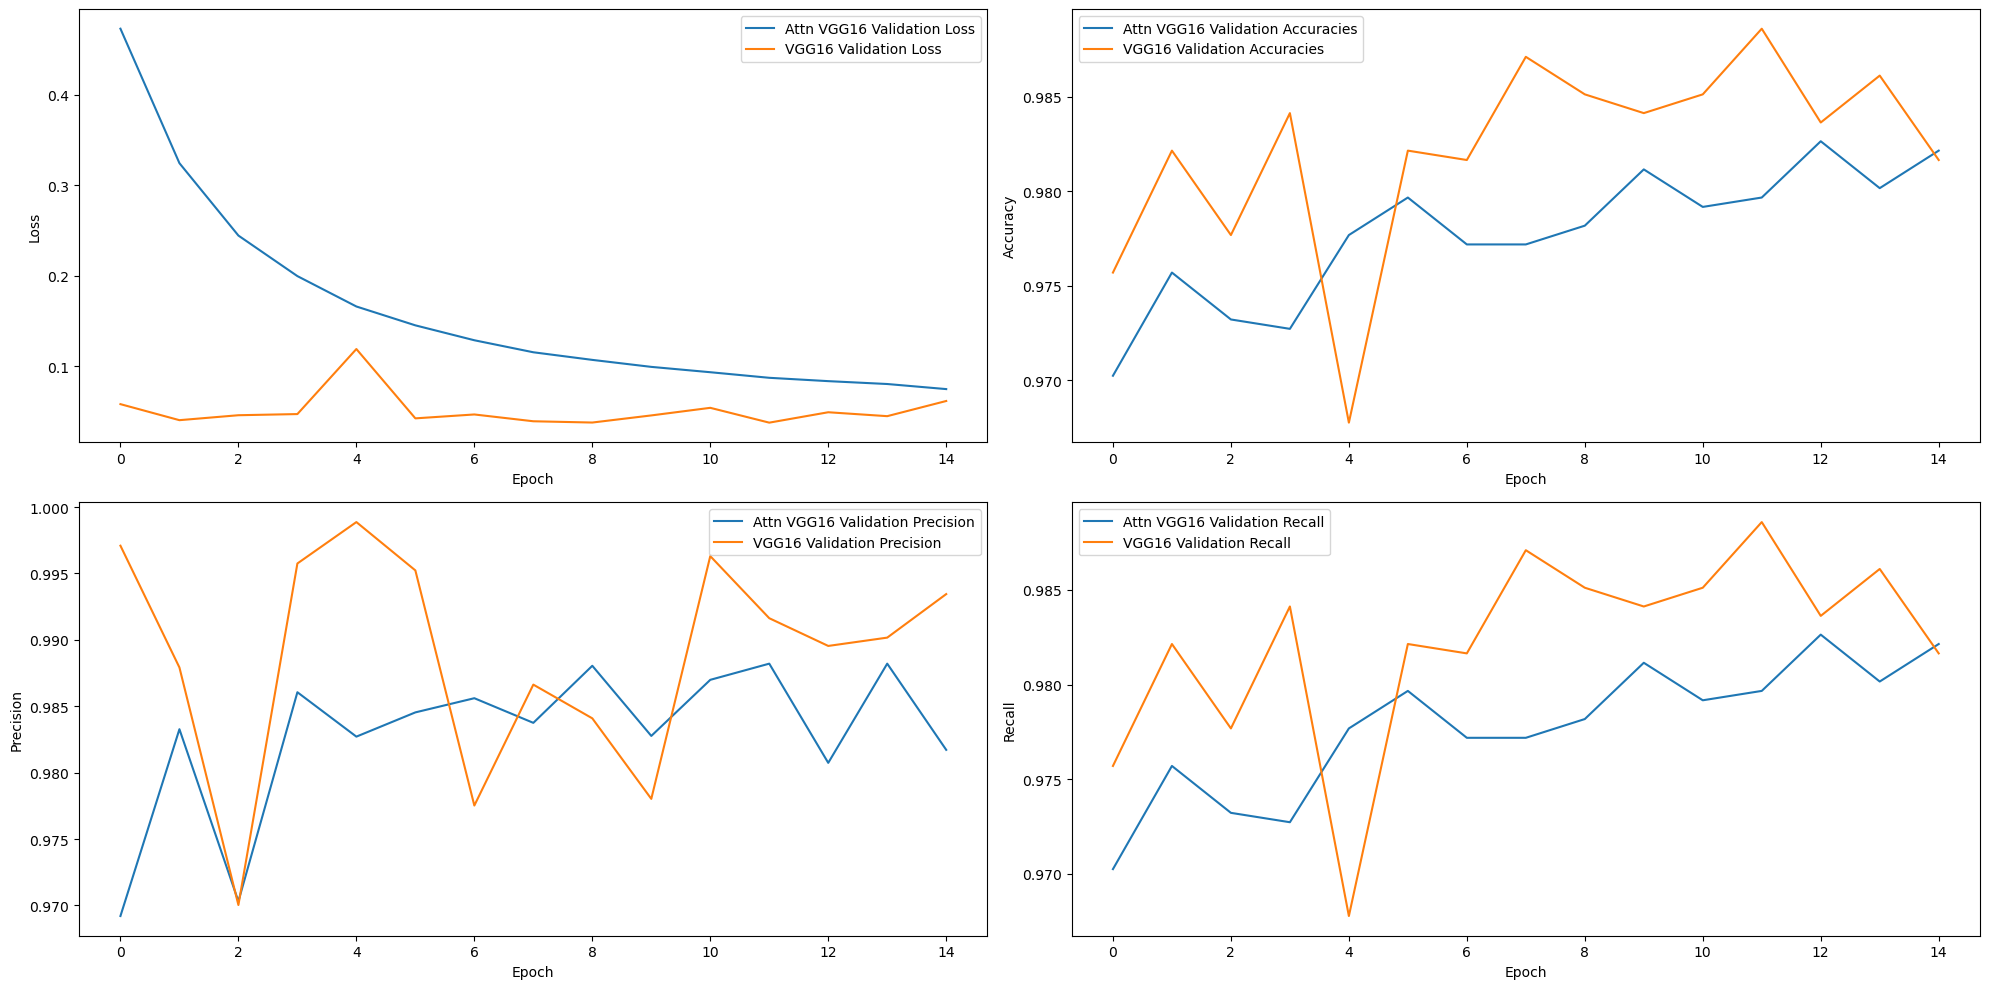

In [37]:
# Plotting the training progress
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(output_val_attn_comparison['val_losses'], label='Attn VGG16 Validation Loss')
plt.plot(output_val_comparison['val_losses'], label='VGG16 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(output_val_attn_comparison['val_accuracies'], label='Attn VGG16 Validation Accuracies')
plt.plot(output_val_comparison['val_accuracies'], label='VGG16 Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(output_val_attn_comparison['val_precisions'], label='Attn VGG16 Validation Precision')
plt.plot(output_val_comparison['val_precisions'], label='VGG16 Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(output_val_attn_comparison['val_recalls'], label='Attn VGG16 Validation Recall')
plt.plot(output_val_comparison['val_recalls'], label='VGG16 Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# Testing with Multiple Objects Image

### Dataset used for testing of multiple object focusing ability of attention VGG16 is provided in the image folder.

In [249]:
filepaths_to_plot = []
targets_to_plot = []

file_names = ['Test/dog/Test_dog1.jpeg', 'Test/dog/Test_dog2.jpeg', 'Test/dog/Test_dog3.jpeg', 'Test/cat/Test_cat1.jpeg', 'Test/cat/Test_cat2.jpeg', 'Test/cat/Test_cat3.png', 'Test/cat/Test_cat4.jpeg']
for file_name in file_names:
    file_path = os.path.join(data_dir, file_name)
    filepaths_to_plot.append(file_path)
    if 'cat/' in file_name:
        targets_to_plot.append(0)
    elif 'dog/' in file_name:
        targets_to_plot.append(1)

data_to_plot = {'images': filepaths_to_plot, 'target': targets_to_plot}
df_to_plot = pd.DataFrame(data_to_plot)

print(df_to_plot)

                                              images  target
0  /Users/kimrui/aiap-projects/Image Classificati...       1
1  /Users/kimrui/aiap-projects/Image Classificati...       1
2  /Users/kimrui/aiap-projects/Image Classificati...       1
3  /Users/kimrui/aiap-projects/Image Classificati...       0
4  /Users/kimrui/aiap-projects/Image Classificati...       0
5  /Users/kimrui/aiap-projects/Image Classificati...       0
6  /Users/kimrui/aiap-projects/Image Classificati...       0


In [250]:
dataset = ImageDataset(data_paths=df_to_plot['images'].values, labels=df_to_plot['target'].values, transform=train_transform)
data_loader = DataLoader(dataset, batch_size=7, shuffle=False)

In [251]:
for batch in data_loader:
    inputs, labels = batch
    inputs_to_plot_test = inputs.to(device)

print(labels)

tensor([1., 1., 1., 0., 0., 0., 0.])


## Attention with Sigmoid Function

In [195]:
model_test= AttnVGG(num_classes=1, normalize_attn=False, dropout=0)
model_test.load_state_dict(torch.load(f'/Users/kimrui/aiap-projects/Image Classification with Attention/model/AttnVGG16_Sigmoid_epoch20.pth'))
model_test.to(device)


Baseline_Grid = utils.make_grid(inputs_to_plot_test, nrow=8, scale_each=True, normalize=True)   
_, a1_test, a2_test = model_test(inputs_to_plot_test)

del model_test

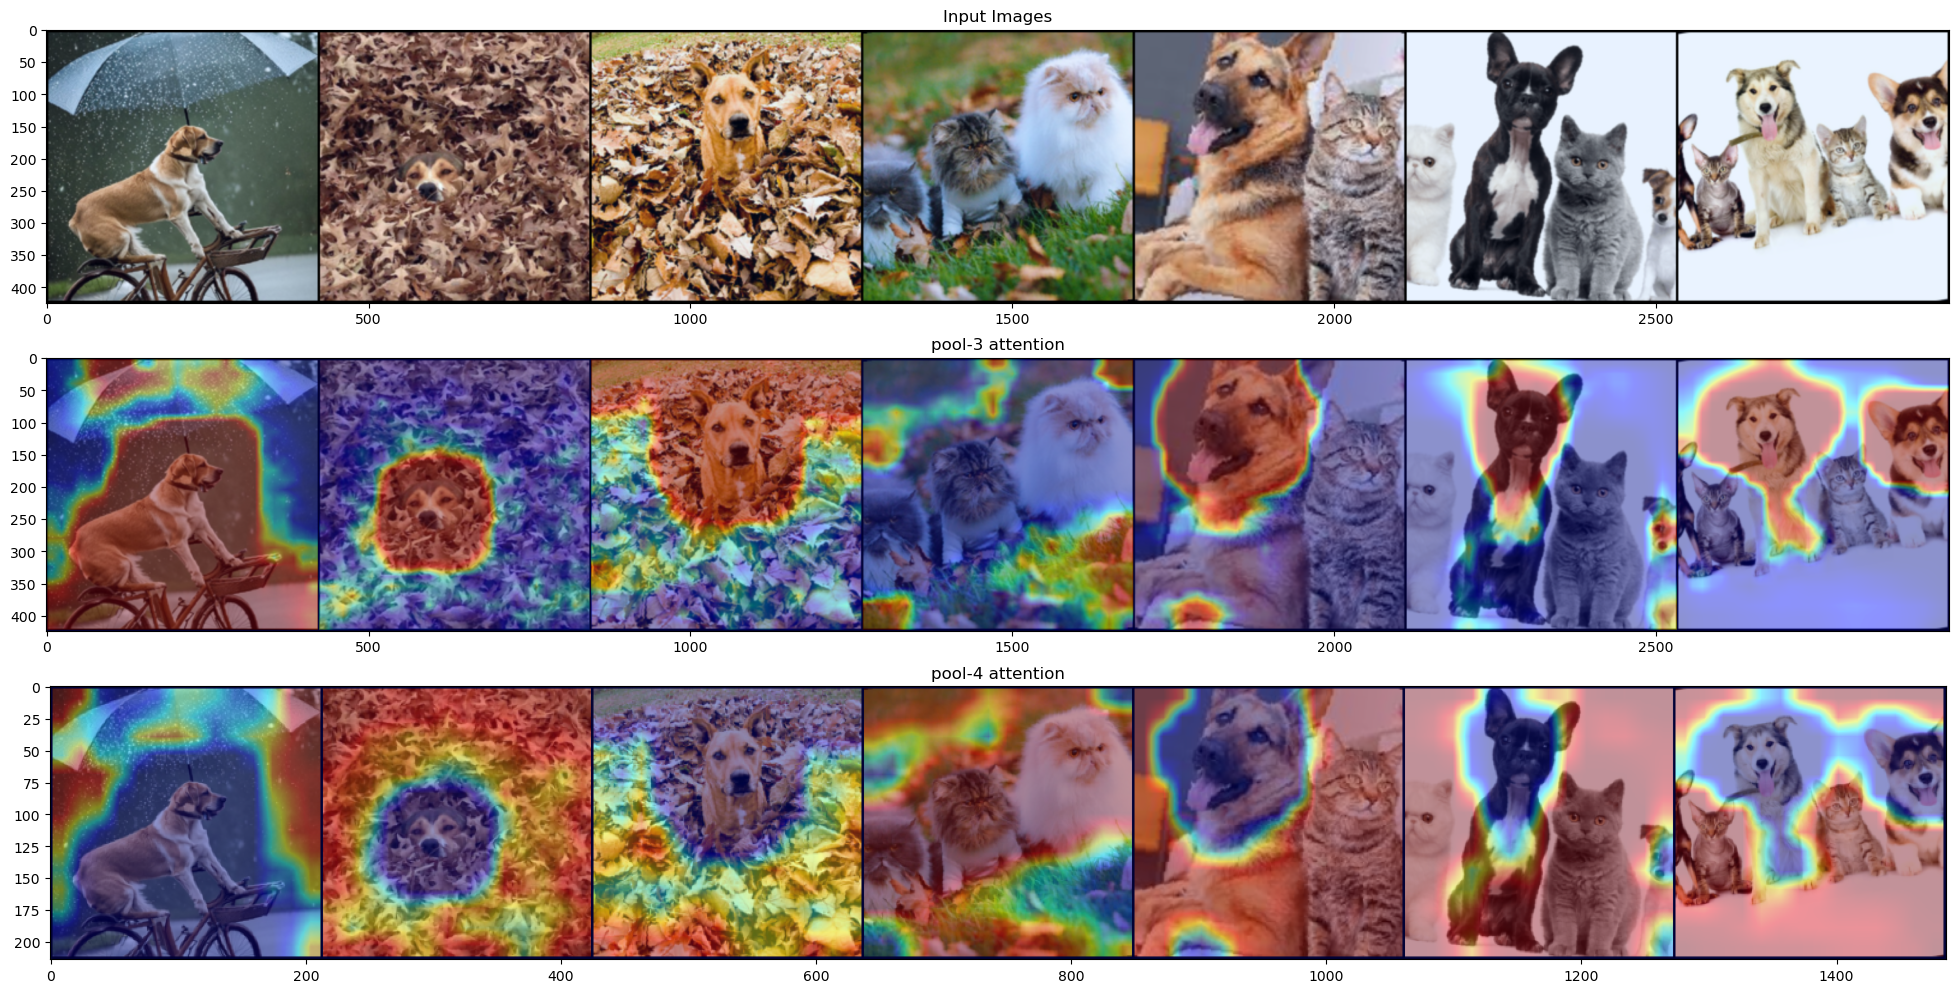

In [198]:
original_img = visualize_attention(Baseline_Grid, a1_test, up_factor=15, no_attention=True)
first_attention = visualize_attention(Baseline_Grid, a1_test, up_factor=15, no_attention=False)
second_attention = visualize_attention(Baseline_Grid, a2_test, up_factor=15, no_attention=False)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(20, 10))

ax1.imshow(original_img)
ax2.imshow(first_attention)
ax3.imshow(second_attention)

ax1.title.set_text('Input Images')
ax2.title.set_text('pool-3 attention')
ax3.title.set_text('pool-4 attention')

plt.tight_layout()
plt.show()

## Attention with Softmax Function

In [254]:
model_test= AttnVGG(num_classes=1, normalize_attn=True, dropout=0)
model_test.load_state_dict(torch.load(f'/Users/kimrui/aiap-projects/Image Classification with Attention/model/AttnVGG16_Softmax_epoch20.pth'))
model_test.to(device)


Baseline_Grid = utils.make_grid(inputs_to_plot_test, nrow=8, scale_each=True, normalize=True)   
_, a1_test, a2_test = model_test(inputs_to_plot_test)

del model_test

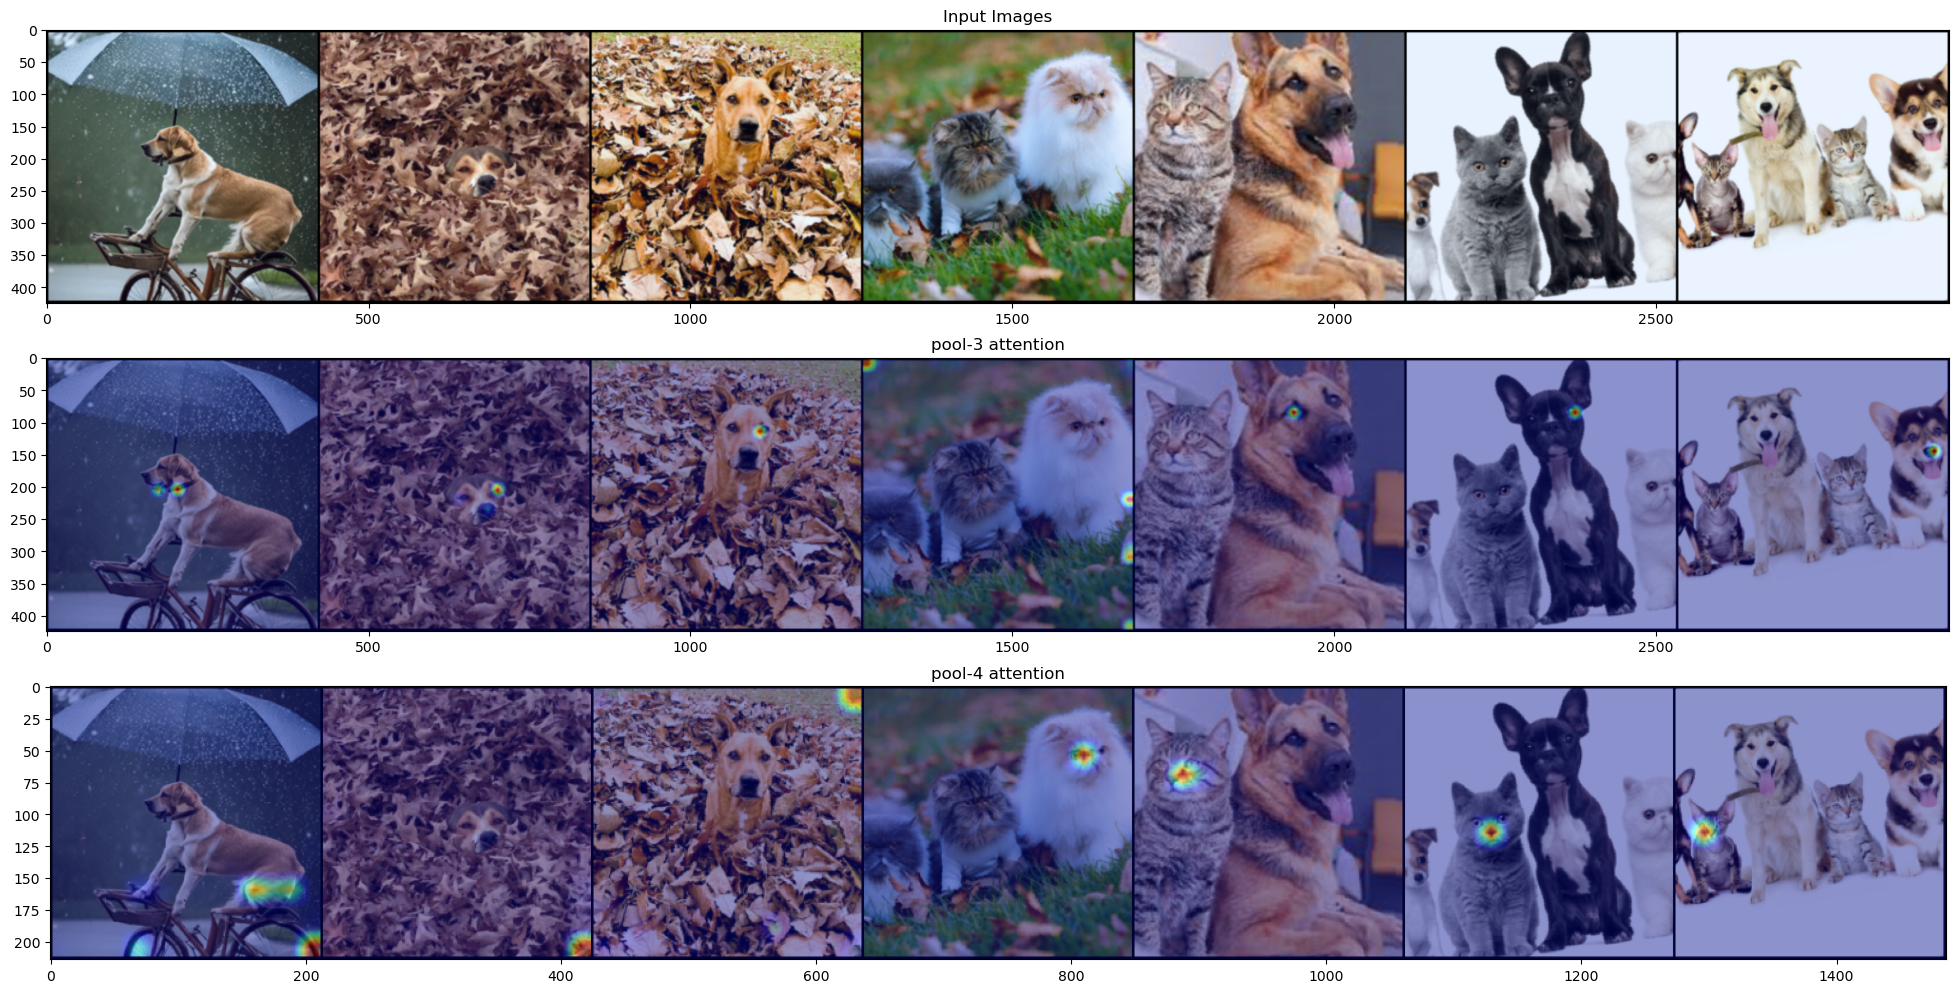

In [255]:
original_img = visualize_attention(Baseline_Grid, a1_test, up_factor=15, no_attention=True)
first_attention = visualize_attention(Baseline_Grid, a1_test, up_factor=15, no_attention=False)
second_attention = visualize_attention(Baseline_Grid, a2_test, up_factor=15, no_attention=False)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(20, 10))

ax1.imshow(original_img)
ax2.imshow(first_attention)
ax3.imshow(second_attention)

ax1.title.set_text('Input Images')
ax2.title.set_text('pool-3 attention')
ax3.title.set_text('pool-4 attention')

plt.tight_layout()
plt.show()

## GRAD-CAM Plot

In [18]:
image_path = df_to_plot['images'].iloc[3]

from PIL import Image
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

model3 = AttnVGG(num_classes=1, normalize_attn=False, dropout=0)
model3.load_state_dict(torch.load(f'/Users/kimrui/aiap-projects/Image Classification with Attention/model/AttnVGG16_Sigmoid_epoch20.pth'))
model3.to(device)

def generate_gradcam_heatmap(image_path,model):
    ''''
    Generates a Grad-CAM heatmap for the given image using the provided model.

    Args:
        image_path (str): The path to the input image.
        model: The model used for generating the Grad-CAM heatmap.

    Returns:
        PIL.Image.Image: The Grad-CAM heatmap overlaid on the input image.
    '''
    img = np.array(Image.open(image_path))
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    input_tensor= input_tensor.to(device)

    # for binary classification 
    targets_binary = [BinaryClassifierOutputTarget(1)]

    # all layers from pool4 attention  
    target_layers = [model.attn2.W_g,model.attn2.W_l,model.attn2.phi]

    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets_binary)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
        
    return Image.fromarray(cam_image)

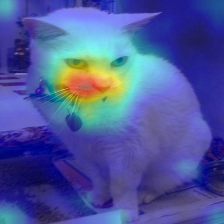

In [19]:
generate_gradcam_heatmap(image_path,model3)